In [1]:
import pandas as pd
import numpy as np
import os


In [6]:
df_train_calc = pd.read_csv('csv/fixed_calc_train_data_geo.csv')
df_test_calc = pd.read_csv('csv/fixed_calc_test_data_geo.csv')
df_train_mass = pd.read_csv('csv/fixed_mass_train_data_geo.csv')
df_test_mass = pd.read_csv('csv/fixed_mass_test_data_geo.csv')

print(df_train_calc.shape)
print(df_test_calc.shape)
print(df_train_mass.shape)
print(df_test_mass.shape)

(1544, 18)
(326, 18)
(1318, 18)
(378, 18)


In [7]:
df_train_calc

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc_type,calc_distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,center_x,center_y,roi_width,roi_height
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,jpeg/1.3.6.1.4.1.9590.100.1.2.4741431601036838...,jpeg/1.3.6.1.4.1.9590.100.1.2.3933440102117190...,jpeg/1.3.6.1.4.1.9590.100.1.2.3933440102117190...,1902.0,2942.0,636.0,548.0
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,jpeg/1.3.6.1.4.1.9590.100.1.2.2505966083112079...,jpeg/1.3.6.1.4.1.9590.100.1.2.2962812078121304...,jpeg/1.3.6.1.4.1.9590.100.1.2.2962812078121304...,1849.0,3554.0,640.0,508.0
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,jpeg/1.3.6.1.4.1.9590.100.1.2.2286996273134871...,jpeg/1.3.6.1.4.1.9590.100.1.2.3141358711119438...,jpeg/1.3.6.1.4.1.9590.100.1.2.3141358711119438...,1684.0,1580.0,536.0,640.0
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,jpeg/1.3.6.1.4.1.9590.100.1.2.1047434104111331...,jpeg/1.3.6.1.4.1.9590.100.1.2.9145827961248551...,jpeg/1.3.6.1.4.1.9590.100.1.2.9145827961248551...,1531.0,2898.0,720.0,648.0
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,jpeg/1.3.6.1.4.1.9590.100.1.2.4067256282138262...,jpeg/1.3.6.1.4.1.9590.100.1.2.2813974946128719...,jpeg/1.3.6.1.4.1.9590.100.1.2.2813974946128719...,1646.0,1959.0,136.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,P_02566,2,RIGHT,MLO,1,calcification,AMORPHOUS-PLEOMORPHIC,SEGMENTAL,5,MALIGNANT,5,jpeg/1.3.6.1.4.1.9590.100.1.2.2151649237113605...,jpeg/1.3.6.1.4.1.9590.100.1.2.1264661801122256...,jpeg/1.3.6.1.4.1.9590.100.1.2.1264661801122256...,2573.0,3974.0,1632.0,1056.0
1540,P_02572,2,LEFT,CC,1,calcification,AMORPHOUS,CLUSTERED,0,MALIGNANT,2,jpeg/1.3.6.1.4.1.9590.100.1.2.3982279533126117...,jpeg/1.3.6.1.4.1.9590.100.1.2.1443954739125701...,jpeg/1.3.6.1.4.1.9590.100.1.2.1443954739125701...,1545.0,3552.0,548.0,488.0
1541,P_02572,2,LEFT,MLO,1,calcification,AMORPHOUS,CLUSTERED,0,MALIGNANT,2,jpeg/1.3.6.1.4.1.9590.100.1.2.8321407701360269...,jpeg/1.3.6.1.4.1.9590.100.1.2.1778337862129055...,jpeg/1.3.6.1.4.1.9590.100.1.2.1778337862129055...,1514.0,5344.0,572.0,480.0
1542,P_02584,1,LEFT,CC,1,calcification,PLEOMORPHIC,SEGMENTAL,0,BENIGN,4,jpeg/1.3.6.1.4.1.9590.100.1.2.1140307131256390...,jpeg/1.3.6.1.4.1.9590.100.1.2.4206976541332171...,jpeg/1.3.6.1.4.1.9590.100.1.2.4206976541332171...,282.0,4623.0,523.0,488.0


# Helper function

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def display_image_rows_final(df, start_index, end_index, image_dir='', max_size=(512, 512)):
    rows = end_index - start_index
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))  # 5 columns now

    if rows == 1:
        axes = [axes]

    for idx, i in enumerate(range(start_index, end_index)):
        row = df.iloc[i]

        full_path = os.path.join(image_dir, row['image_file_path'])
        roi_path = os.path.join(image_dir, row['ROI_mask_file_path'])
        cropped_path = os.path.join(image_dir, row['cropped_image_file_path'])

        try:
            # Load and convert images to grayscale
            full_img = Image.open(full_path).convert("L")
            roi_img = Image.open(roi_path).convert("L")
            cropped_img = Image.open(cropped_path).convert("L")

            # Resize proportionally (for full & cropped), force ROI to match full
            full_img.thumbnail(max_size)
            cropped_img.thumbnail(max_size)
            roi_img = roi_img.resize(full_img.size)

            # Create masked image: white in mask keeps original pixel, black -> 0
            full_array = np.array(full_img)
            roi_array = np.array(roi_img)
            masked_array = np.where(roi_array == 255, full_array, 0).astype(np.uint8)
            masked_img = Image.fromarray(masked_array)

            # --- CROP MASKED REGION FROM MASKED IMAGE ---
            y_indices, x_indices = np.where(roi_array == 255)

            if len(x_indices) == 0 or len(y_indices) == 0:
                raise ValueError("Empty ROI mask")

            # Get center and bounding box
            x_center = int(np.mean(x_indices))
            y_center = int(np.mean(y_indices))
            width = max(x_indices) - min(x_indices)
            height = max(y_indices) - min(y_indices)
            square_size = int(max(width, height) * 1.2)  # Add 20% padding

            # Define crop box, clamp within image bounds
            x1 = max(0, x_center - square_size // 2)
            y1 = max(0, y_center - square_size // 2)
            x2 = min(masked_img.width, x1 + square_size)
            y2 = min(masked_img.height, y1 + square_size)

            cropped_masked_img = masked_img.crop((x1, y1, x2, y2))

        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue

        # Plot images
        axes[idx][0].imshow(full_img, cmap='gray')
        axes[idx][0].set_title(f'Original Image [{i}]')

        axes[idx][1].imshow(roi_img, cmap='gray')
        axes[idx][1].set_title('ROI Mask')

        axes[idx][2].imshow(cropped_img, cmap='gray')
        axes[idx][2].set_title('Cropped ROI')

        axes[idx][3].imshow(masked_img, cmap='gray')
        axes[idx][3].set_title('Masked Original')

        axes[idx][4].imshow(cropped_masked_img, cmap='gray')
        axes[idx][4].set_title('Cropped Masked ROI')

        for ax in axes[idx]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


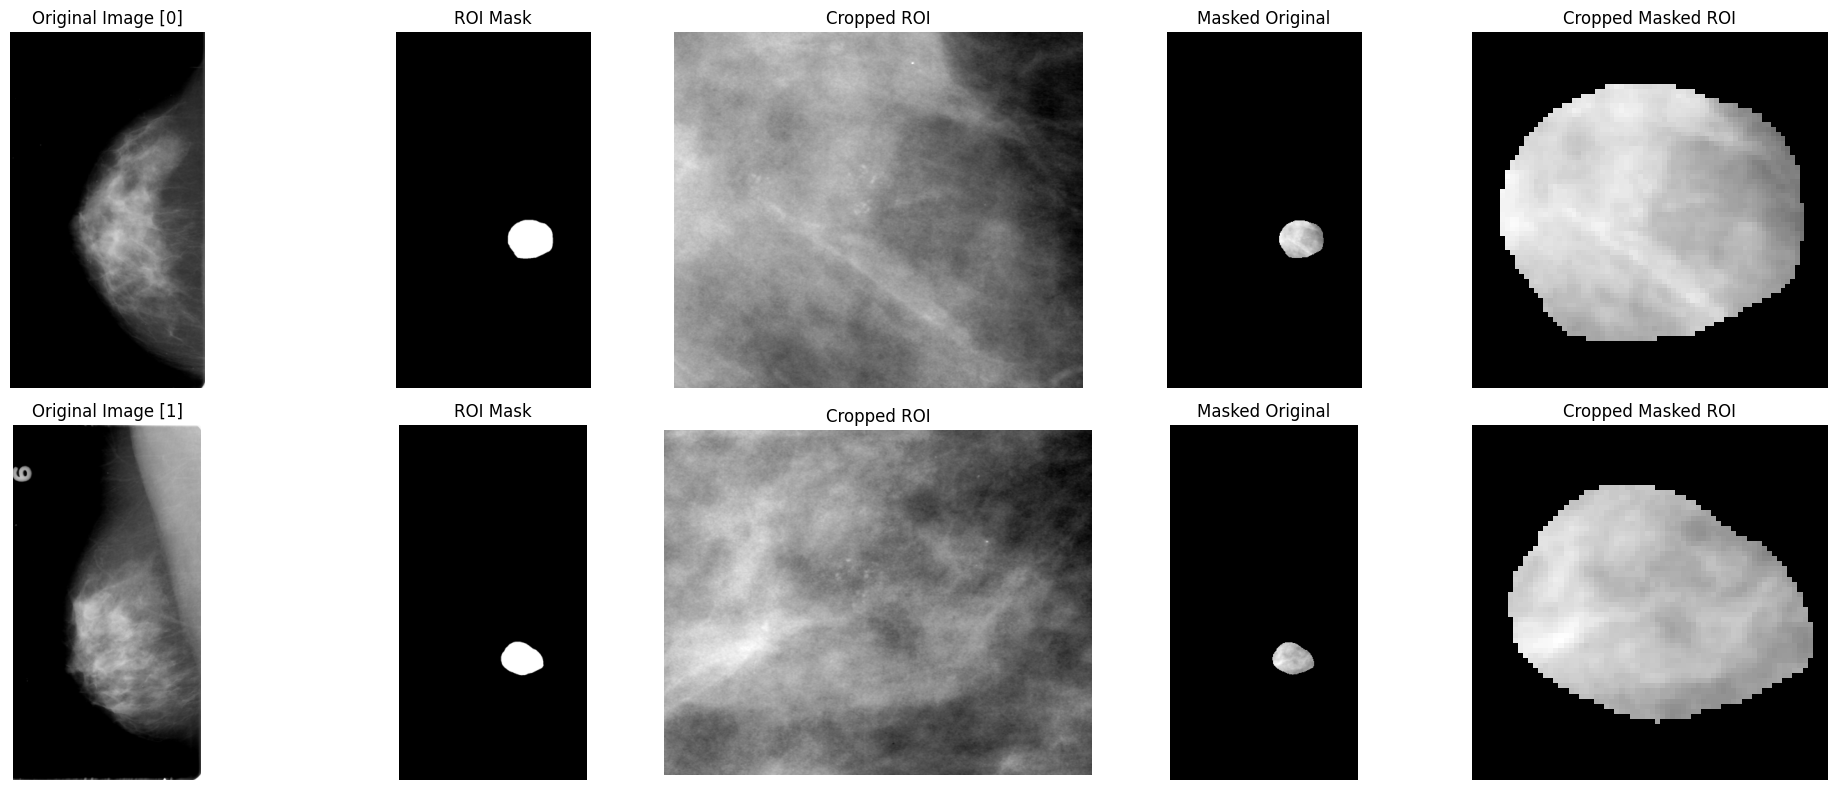

In [18]:
display_image_rows_final(df_train_calc, 0, 2, image_dir='')

In [13]:
df_train_mass

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,center_x,center_y,roi_width,roi_height
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,jpeg/1.3.6.1.4.1.9590.100.1.2.3423861948112676...,jpeg/1.3.6.1.4.1.9590.100.1.2.2967364033137925...,jpeg/1.3.6.1.4.1.9590.100.1.2.2967364033137925...,443,2639,390,474
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,jpeg/1.3.6.1.4.1.9590.100.1.2.3593083293123978...,jpeg/1.3.6.1.4.1.9590.100.1.2.2279552747112257...,jpeg/1.3.6.1.4.1.9590.100.1.2.2279552747112257...,375,3096,215,250
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,jpeg/1.3.6.1.4.1.9590.100.1.2.8918004621102253...,jpeg/1.3.6.1.4.1.9590.100.1.2.4291204140118329...,jpeg/1.3.6.1.4.1.9590.100.1.2.4291204140118329...,1612,3709,381,425
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,jpeg/1.3.6.1.4.1.9590.100.1.2.2953609263134927...,jpeg/1.3.6.1.4.1.9590.100.1.2.1151342321130015...,jpeg/1.3.6.1.4.1.9590.100.1.2.1151342321130015...,1844,3247,380,386
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,jpeg/1.3.6.1.4.1.9590.100.1.2.4105247549130579...,jpeg/1.3.6.1.4.1.9590.100.1.2.1285736631262570...,jpeg/1.3.6.1.4.1.9590.100.1.2.1285736631262570...,914,3974,423,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,jpeg/1.3.6.1.4.1.9590.100.1.2.3997425356118931...,jpeg/1.3.6.1.4.1.9590.100.1.2.3876700510138449...,jpeg/1.3.6.1.4.1.9590.100.1.2.9466221711350105...,1778,3474,311,292
1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,jpeg/1.3.6.1.4.1.9590.100.1.2.1740870370123119...,jpeg/1.3.6.1.4.1.9590.100.1.2.6832110011366565...,jpeg/1.3.6.1.4.1.9590.100.1.2.3035467126130511...,1972,2455,340,316
1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,jpeg/1.3.6.1.4.1.9590.100.1.2.4125580508117226...,jpeg/1.3.6.1.4.1.9590.100.1.2.3753195874110159...,jpeg/1.3.6.1.4.1.9590.100.1.2.3873256622116520...,1495,2561,327,292
1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,jpeg/1.3.6.1.4.1.9590.100.1.2.1503114225120728...,jpeg/1.3.6.1.4.1.9590.100.1.2.3142027521108604...,jpeg/1.3.6.1.4.1.9590.100.1.2.2374051592126955...,441,2960,240,279


# Classification of abnormality type

In [15]:
columns_1 = ['image_file_path', 'cropped_image_file_path', 'ROI_mask_file_path', 
           'center_x', 'center_y', 'roi_width', 'roi_height']

df_train_calc = pd.read_csv('csv/fixed_calc_train_data_geo.csv')
df_test_calc = pd.read_csv('csv/fixed_calc_test_data_geo.csv')
df_train_mass = pd.read_csv('csv/fixed_mass_train_data_geo.csv')
df_test_mass = pd.read_csv('csv/fixed_mass_test_data_geo.csv')

print(df_train_calc.shape)
print(df_test_calc.shape)
print(df_train_mass.shape)
print(df_test_mass.shape)

df_train_calc['abnormality_type'] = 0  # calcification
df_test_calc['abnormality_type'] = 0
df_train_mass['abnormality_type'] = 1  # mass
df_test_mass['abnormality_type'] = 1
df_train = pd.concat([df_train_calc, df_train_mass], ignore_index=True)
df_test = pd.concat([df_test_calc, df_test_mass], ignore_index=True)

(1544, 18)
(326, 18)
(1318, 18)
(378, 18)


In [54]:
import os
import pandas as pd
from PIL import Image
import shutil

# Reuse the previously defined df_train and df_test
# These would typically be loaded from actual CSVs or original DataFrames

# Assume JPEG folder is relative to this script's root
jpeg_root = "jpeg"

# Output folders
base_path = "dataset/yolo8_label_roi_1024"
paths = {
    "train_images": os.path.join(base_path, "images/train"),
    "val_images": os.path.join(base_path, "images/val"),
    "train_labels": os.path.join(base_path, "labels/train"),
    "val_labels": os.path.join(base_path, "labels/val"),
}

# Create necessary folders
for path in paths.values():
    os.makedirs(path, exist_ok=True)

# Helper to process each DataFrame (train or test)
def process_dataframe(df, image_dir, label_dir, target_size=1024):
    for idx, row in df.iterrows():
        src_path = row['image_file_path']
        class_id = row['abnormality_type']
        center_x = row['center_x']
        center_y = row['center_y']
        width = row['roi_width']
        height = row['roi_height']

        # Extract clean filename
        # file_id = raw_path.split('.')[-2]  # Extract long number at the end
        # filename = f"{file_id}.jpeg"
        filename = os.path.basename(src_path)
        dst_image_path = os.path.join(image_dir, filename)
        dst_label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
        

        # Copy image and load to get size
        try:
            shutil.copyfile(src_path, dst_image_path)
            with Image.open(dst_image_path) as img:
                orig_w, orig_h = img.size

                # Determine scaling factor (fit to max 640px, preserving aspect ratio)
                target_size = target_size
                scale = target_size / max(orig_w, orig_h)
                new_w, new_h = int(orig_w * scale), int(orig_h * scale)

                # Resize image
                img = img.resize((new_w, new_h))
                img.save(dst_image_path)

                # Normalize bbox coords to resized image size
                scaled_center_x = center_x * scale / new_w
                scaled_center_y = center_y * scale / new_h
                scaled_width = width * scale / new_w
                scaled_height = height * scale / new_h

                # Write YOLO label file
                with open(dst_label_path, 'w') as f:
                    f.write(f"{class_id} {scaled_center_x:.6f} {scaled_center_y:.6f} {scaled_width:.6f} {scaled_height:.6f}\n")

        except Exception as e:
            print(f"Error processing {src_path}: {e}")

# Process both train and test datasets
process_dataframe(df_train, paths["train_images"], paths["train_labels"])
process_dataframe(df_test, paths["val_images"], paths["val_labels"])

# Write the YAML file
yaml_content = f"""
path: /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024
train: images/train
val: images/val

nc: 2
names: ["calcification", "mass"]
"""

yaml_path = os.path.join(base_path, "mammogram.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

yaml_path


'dataset/yolo8_label_roi_1024/mammogram.yaml'

## correct one, but no scaling

In [20]:
import os
import shutil
import pandas as pd

# Load your DataFrames
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')

# For this example, assume df_train and df_test already loaded

# Directory setup
base_dir = 'dataset/yolo8_label_roi'
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

os.makedirs(os.path.join(images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(images_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'val'), exist_ok=True)

def process_split(df, split):
    for idx, row in df.iterrows():
        src_path = row['image_file_path']
        # Extract unique filename (after last '/')
        filename = os.path.basename(src_path)
        target_image_path = os.path.join(images_dir, split, filename)
        target_label_path = os.path.join(labels_dir, split, filename.replace('.jpg', '.txt'))
        
        # Copy image
        try:
            shutil.copy(src_path, target_image_path)
        except Exception as e:
            print(f"Could not copy {src_path}: {e}")
            continue

        # Create YOLO label file
        class_id = int(row['abnormality_type'])
        cx = float(row['center_x'])
        cy = float(row['center_y'])
        w = float(row['roi_width'])
        h = float(row['roi_height'])
        label_line = f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n"

        with open(target_label_path, 'w') as f:
            f.write(label_line)

# Process train and val splits
process_split(df_train, 'train')
process_split(df_test, 'val')

# Write the YOLO dataset YAML
yaml_content = """\
path: dataset/yolo8_label_roi
train: images/train
val: images/val

nc: 2
names: ["calcification", "mass"]
"""

with open(os.path.join(base_dir, "mammogram.yaml"), "w") as f:
    f.write(yaml_content)

print("Dataset prepared for YOLO training!")


Dataset prepared for YOLO training!


# One epoch in CPU

In [55]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 model (choose variant: n, s, m, l, x)
model = YOLO("yolov8n.pt")  # Try yolov8m.pt or yolov8s.pt for better accuracy

# Train the model
model.train(
    data="/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml",  # path to your YAML
    epochs=1,             # adjust depending on your dataset size
    imgsz=1024,             # image size used in preprocessing
    batch=8,                # adjust to fit your GPU memory
    patience=20,            # early stopping
    project="yolo8_mammo",  # folder name for training logs/weights
    name="exp",             # sub-folder
    exist_ok=True           # overwrite if folder exists
)


Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml, epochs=1, time=None, patience=20, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo8_mammo, name=exp, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/train... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 2482.62it/s]

train: New cache created: /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.5±18.2 MB/s, size: 28.6 KB)



val: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/val... 296 images, 0 backgrounds, 0 corrupt: 100%|██████████| 296/296 [00:00<00:00, 3124.20it/s]

val: New cache created: /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/val.cache
Plotting labels to yolo8_mammo/exp/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to yolo8_mammo/exp
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.413      7.217      1.873          5       1024: 100%|██████████| 38/38 [02:58<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:41<00:00,  5.37s/it]


                   all        296        296   0.000713      0.161   0.000556   0.000155

1 epochs completed in 0.078 hours.
Optimizer stripped from yolo8_mammo/exp/weights/last.pt, 6.2MB
Optimizer stripped from yolo8_mammo/exp/weights/best.pt, 6.2MB

Validating yolo8_mammo/exp/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 CPU (Apple M2 Pro)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:39<00:00,  5.26s/it]


                   all        296        296   0.000742      0.166   0.000573    0.00016
         calcification         20         20   2.84e-05       0.05   1.55e-05   1.55e-06
                  mass        276        276    0.00146      0.283    0.00113   0.000319
Speed: 2.1ms preprocess, 295.6ms inference, 0.0ms loss, 36.0ms postprocess per image
Results saved to yolo8_mammo/exp


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x2cf939520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# One epoch with MPS

In [58]:
import torch
print(torch.backends.mps.is_available())  # Should return True
print(torch.backends.mps.is_built())      # Should also return True

from ultralytics import YOLO

# Load a pretrained YOLOv8 model (choose variant: n, s, m, l, x)
model = YOLO("yolov8n.pt")  # Try yolov8m.pt or yolov8s.pt for better accuracy

# Train the model
model.train(
    data="/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml",  # path to your YAML
    epochs=1,             # adjust depending on your dataset size
    imgsz=1024,             # image size used in preprocessing
    batch=8,                # adjust to fit your GPU memory
    patience=20,            # early stopping
    project="yolo8_mammo_gpu",  # folder name for training logs/weights
    name="exp",             # sub-folder
    exist_ok=True,           # overwrite if folder exists
    device='mps'  # Use Metal Performance Shaders (MPS) for Mac GPUs
)


True
True
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml, epochs=1, time=None, patience=20, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=mps, workers=8, project=yolo8_mammo_gpu, name=exp, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

train: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/train.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 86.9±16.6 MB/s, size: 28.6 KB)



val: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/val.cache... 296 images, 0 backgrounds, 0 corrupt: 100%|██████████| 296/296 [00:00<?, ?it/s]

Plotting labels to yolo8_mammo_gpu/exp/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to yolo8_mammo_gpu/exp
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.44G      2.397       7.12      1.872          5       1024: 100%|██████████| 38/38 [01:10<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:12<00:23,  7.80s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:53<00:00,  9.11s/it]


                   all        296        296   0.000409     0.0793   0.000261   8.68e-05

1 epochs completed in 0.069 hours.
Optimizer stripped from yolo8_mammo_gpu/exp/weights/last.pt, 6.2MB
Optimizer stripped from yolo8_mammo_gpu/exp/weights/best.pt, 6.2MB

Validating yolo8_mammo_gpu/exp/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 MPS (Apple M2 Pro)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.21s/it]


                   all        296        296   0.000388     0.0775   0.000253   7.76e-05
         calcification         20         20   1.98e-05       0.05   1.13e-05   1.13e-06
                  mass        276        276   0.000756      0.105   0.000495   0.000154
Speed: 2.7ms preprocess, 82.4ms inference, 0.0ms loss, 35.8ms postprocess per image
Results saved to yolo8_mammo_gpu/exp


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x2cf85b140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# 5 epochs in GPU

In [59]:
import torch
print(torch.backends.mps.is_available())  # Should return True
print(torch.backends.mps.is_built())      # Should also return True

from ultralytics import YOLO

# Load a pretrained YOLOv8 model (choose variant: n, s, m, l, x)
model = YOLO("yolov8n.pt")  # Try yolov8m.pt or yolov8s.pt for better accuracy

# Train the model
model.train(
    data="/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml",  # path to your YAML
    epochs=5,             # adjust depending on your dataset size
    imgsz=1024,             # image size used in preprocessing
    batch=8,                # adjust to fit your GPU memory
    patience=20,            # early stopping
    project="yolo8_mammo_gpu_5",  # folder name for training logs/weights
    name="exp",             # sub-folder
    exist_ok=True,           # overwrite if folder exists
    device='mps'  # Use Metal Performance Shaders (MPS) for Mac GPUs
)


True
True
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml, epochs=5, time=None, patience=20, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=mps, workers=8, project=yolo8_mammo_gpu_5, name=exp, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

train: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/train.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 79.9±14.7 MB/s, size: 28.6 KB)



val: Scanning /Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/labels/val.cache... 296 images, 0 backgrounds, 0 corrupt: 100%|██████████| 296/296 [00:00<?, ?it/s]

Plotting labels to yolo8_mammo_gpu_5/exp/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to yolo8_mammo_gpu_5/exp
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.68G      2.438      7.093      1.916          5       1024: 100%|██████████| 38/38 [00:56<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:53<00:00,  2.83s/it]

                   all        296        296    0.00013     0.0145   6.87e-05   1.48e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.85G       2.06      5.122      1.674          6       1024: 100%|██████████| 38/38 [01:56<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:05<01:38,  5.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:12<01:46,  6.26s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:20<01:52,  7.04s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:28<01:54,  7.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:35<01:40,  7.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:40<01:25,  6.60s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:48<01:23,  7.00s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [00:54<01:13,  6.65s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [01:00<01:04,  6.48s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:06<00:56,  6.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:11<00:47,  5.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:19<00:45,  6.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:25<00:37,  6.26s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:30<00:30,  6.07s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:36<00:23,  5.98s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [01:42<00:17,  5.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [01:48<00:12,  6.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [01:55<00:06,  6.34s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:01<00:00,  6.40s/it]


                   all        296        296    0.00166      0.139     0.0193    0.00719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.96G      2.039      4.735      1.638          8       1024: 100%|██████████| 38/38 [02:31<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:07<02:11,  7.29s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:16<02:20,  8.25s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:25<02:15,  8.50s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:33<02:08,  8.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:40<01:52,  8.04s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:48<01:44,  8.04s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:57<01:38,  8.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [01:05<01:28,  8.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [01:12<01:17,  7.70s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:19<01:07,  7.50s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:26<00:59,  7.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:34<00:54,  7.77s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:44<00:50,  8.41s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:50<00:38,  7.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:58<00:30,  7.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:04<00:21,  7.09s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [02:12<00:14,  7.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [02:20<00:07,  7.65s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:28<00:00,  7.82s/it]


                   all        296        296      0.683     0.0157     0.0147    0.00619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.05G      1.951      4.041      1.582          7       1024: 100%|██████████| 38/38 [03:09<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:06<02:02,  6.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:17<02:31,  8.91s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:31<02:58, 11.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:39<02:30, 10.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:46<02:04,  8.87s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:54<01:51,  8.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [01:02<01:42,  8.57s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [01:10<01:30,  8.23s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [01:15<01:12,  7.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:21<01:03,  7.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:28<00:56,  7.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:37<00:52,  7.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:43<00:41,  6.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:49<00:33,  6.70s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:54<00:25,  6.33s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:00<00:18,  6.26s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [02:09<00:13,  6.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [02:18<00:07,  7.55s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:24<00:00,  7.60s/it]


                   all        296        296      0.603     0.0254     0.0132    0.00583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.15G      1.888      3.989      1.553          8       1024: 100%|██████████| 38/38 [03:25<00:00,  5.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:08<02:35,  8.63s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:16<02:23,  8.46s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:26<02:19,  8.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:34<02:11,  8.75s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:41<01:50,  7.91s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:50<01:47,  8.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [01:01<01:52,  9.39s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [01:09<01:35,  8.69s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [01:16<01:22,  8.23s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [01:27<01:22,  9.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [01:35<01:10,  8.75s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:45<01:03,  9.11s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 13/19 [01:50<00:47,  7.94s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:59<00:40,  8.12s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [02:08<00:34,  8.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [02:15<00:23,  7.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [02:21<00:15,  7.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [02:27<00:07,  7.06s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:33<00:00,  8.09s/it]


                   all        296        296      0.616      0.029     0.0168    0.00675

5 epochs completed in 0.382 hours.
Optimizer stripped from yolo8_mammo_gpu_5/exp/weights/last.pt, 6.2MB
Optimizer stripped from yolo8_mammo_gpu_5/exp/weights/best.pt, 6.2MB

Validating yolo8_mammo_gpu_5/exp/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.6.0 MPS (Apple M2 Pro)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:04<01:29,  5.00s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:11<01:37,  5.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:17<01:34,  5.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        | 4/19 [00:23<01:32,  6.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▋       | 5/19 [00:29<01:23,  5.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 6/19 [00:33<01:07,  5.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 7/19 [00:39<01:04,  5.40s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 8/19 [00:43<00:57,  5.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 9/19 [00:48<00:48,  4.89s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 10/19 [00:53<00:46,  5.12s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 11/19 [00:59<00:42,  5.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 12/19 [01:07<00:43,  6.15s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▎  | 14/19 [01:14<00:23,  4.71s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 15/19 [01:20<00:19,  4.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 16/19 [01:26<00:15,  5.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 17/19 [01:31<00:10,  5.36s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▍| 18/19 [01:37<00:05,  5.38s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:41<00:00,  5.35s/it]


                   all        296        296    0.00169       0.18     0.0329     0.0124
         calcification         20         20    7.9e-05        0.1   5.92e-05   2.79e-05
                  mass        276        276     0.0033      0.261     0.0658     0.0247
Speed: 6.4ms preprocess, 73.7ms inference, 0.0ms loss, 242.0ms postprocess per image
Results saved to yolo8_mammo_gpu_5/exp


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x2a380fce0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import torch
print(torch.backends.mps.is_available())  # Should return True
print(torch.backends.mps.is_built())      # Should also return True

from ultralytics import YOLO

# Load a pretrained YOLOv8 model (choose variant: n, s, m, l, x)
model = YOLO("yolov8n.pt")  # Try yolov8m.pt or yolov8s.pt for better accuracy

# Train the model
model.train(
    data="/Users/pangyen/Documents/nus mod py/y3s2/cs3264/project/dataset/yolo8_label_roi_1024/mammogram.yaml",  # path to your YAML
    epochs=5,             # adjust depending on your dataset size
    imgsz=1024,             # image size used in preprocessing
    batch=8,                # adjust to fit your GPU memory
    patience=20,            # early stopping
    val=True,  # or False
    val_period=5
    project="yolo8_mammo_gpu_20",  # folder name for training logs/weights
    name="exp",             # sub-folder
    exist_ok=True,           # overwrite if folder exists
    device='mps'  # Use Metal Performance Shaders (MPS) for Mac GPUs
)
